In [18]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_braket_provider import AWSBraketProvider

provider = AWSBraketProvider()
circuit = QuantumCircuit(3, 3)


In [2]:
# Apply H-gate to the first qubit:
circuit.h(0)


# Apply a CNOT to each qubit:
for qubit in range(1, 3):
    circuit.cx(0, qubit)

circuit.measure([0,1,2], [0,1,2])

In [3]:
sv1_device = provider.get_backend("SV1")
sv1_task = sv1_device.run(circuit, shots=10)
sv1_arn = sv1_task.job_id()

# plot_histogram(rigetti_task.result().get_counts())

KeyboardInterrupt: 

In [4]:
print(rigetti_task)
print(rigetti_arn)

arn:aws:braket:us-east-1:557115335303:quantum-task/2a3df166-3627-4e98-8d7c-c5f77094cc28


In [8]:
retrieved = rigetti_device.retrieve_job(rigetti_arn)
print(retrieved)
print(retrieved.result())

Result(backend_name='BraketBackend[SV1]', backend_version='2', qobj_id='0', job_id='arn:aws:braket:us-east-1:557115335303:quantum-task/2a3df166-3627-4e98-8d7c-c5f77094cc28', success=True, results=[ExperimentResult(shots=10, success=True, meas_level=2, data=ExperimentResultData(counts={'111': 5, '000': 5}, memory=['111', '111', '111', '000', '000', '000', '111', '111', '000', '000']), status=COMPLETED)], date=None, status=JobStatus.DONE, header=None)


In [19]:
######## REF: https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler, BackendSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

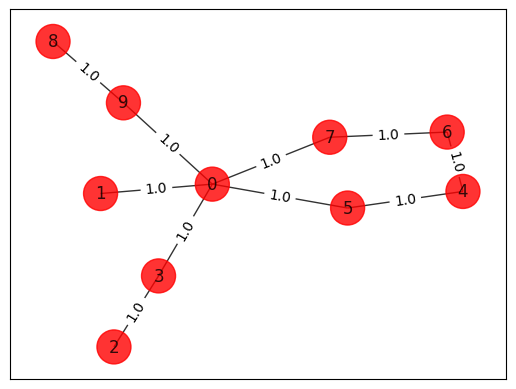

In [52]:
# Generating a graph of 4 nodes
dn = 10
elist = []
for i in range(0, dn, 1):
    if i % 2 == 0:
        elist.append((i, i + 1, 1.0))
    else:
        elist.append((i, 0, 1.0))

# elist.append((4, 6, 1.0))
# elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 8, 1.0), (8, 9, 1.0), (9, 0, 1.0), (3, 10, 1.0), (10, 11, 1.0), (11, 12, 1.0)]
n = len(elist)  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)
G.add_edge(4, 6, weight=1.0)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [53]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 0, 1, 0, 

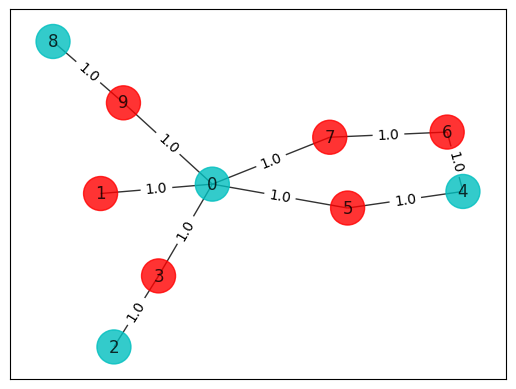

In [54]:
#### Classical solution
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [55]:
import warnings
from abc import abstractmethod
from collections.abc import Sequence
from copy import copy
from typing import Generic, TypeVar
from qiskit.circuit.parametertable import ParameterView
from datetime import datetime

# class SomeClass:
#     def __init__(self, number):
#         print(f'base started 2 - {number}')

# class SomeImpl(SomeClass):
#     # def __init__(self):
#     #     super().__init__()

#     def someMethod(self):
#         print('method')

# class QCompSampler(BackendSampler):
#     def __init__(self, backend, options):
#         super().__init__(backend, options=options)
class QCompSampler(Sampler):
    def __init__(self):
        super().__init__()
        self.__run_cnt = 0
        self.__n_of_circuits = 0

    def run(self, circuits, parameter_values, **run_options,):
        if self.__run_cnt == None:
            self.__run_cnt = 0
        self.__run_cnt += 1
        self.__n_of_circuits += len(circuits)
        print(f'#QCOMPSAMPLER: run called {self.__run_cnt} times... - {datetime.now()} - total n. of ckts: {self.__n_of_circuits} - args: {circuits} - {parameter_values} - {run_options}')
        return super().run(circuits, parameter_values, **run_options)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_5 - 2*x_0*x_7 - 2*x_0*x_9 - 2*x_2*x_3
  - 2*x_4*x_5 - 2*x_4*x_6 - 2*x_6*x_7 - 2*x_8*x_9 + 5*x_0 + x_1 + x_2 + 2*x_3
  + 2*x_4 + 2*x_5 + 2*x_6 + 2*x_7 + x_8 + 2*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Offset: -5.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIZIIIIZ', 'IIZIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZZIIIIII', 'ZZIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j])
#QCOMPSAMPLER: run called 1 times... - 2023-11-28 08:32:01.337235 - total n. of ckts: 50 - args: [<qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x16b70c9a0>, <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x16b70c9a0>, <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x16b70c9a0>, <qiskit.circuit.library.n_local.two_local.Two

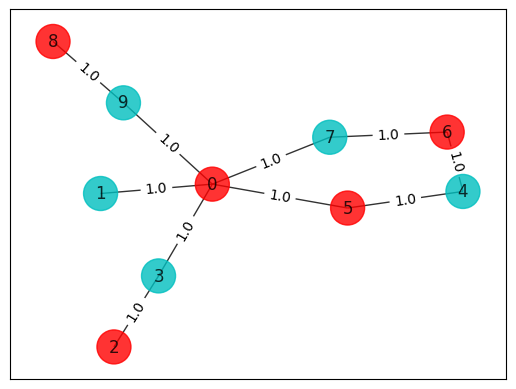

In [56]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
aws_backend = provider.get_backend("SV1")
# aws_sampler = QCompSampler(aws_backend, options={"shots":1000})
no_aws_sampler = QCompSampler()
vqe = SamplingVQE(sampler=no_aws_sampler, ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)